In [1]:
import os
from glob import glob
from typing import Dict, List, Optional, Tuple, Union

import dask
import dask.array as da
import dask.bag
import matplotlib.pyplot as plt
import numpy as np
from dask.diagnostics import ProgressBar
from dask.distributed import Client
from PIL import Image
from tqdm import tqdm

pbar = ProgressBar()
pbar.register()


%matplotlib inline

data_dir = "/media/xultaeculcis/2TB/datasets/sr/fine-tuning/wc/weather"
output_dir = os.path.join(data_dir, "scaled")

In [2]:
variables = [
    "pre",
    "tmin",
    "tmax",
]
resolutions = ["2.5m"]


def get_files(
    data_dir: str, variables: List[str], resolutions: List[str]
) -> Dict[str, Dict[str, List[str]]]:
    results = {}
    for var in variables:
        results[var] = {}
        for res in resolutions:
            pattern = os.path.join(data_dir, var, "**", f"*_{res}*.tif")
            print(pattern)
            results[var][res] = sorted(glob(pattern, recursive=True))

    return results


fpaths = get_files(data_dir, variables, resolutions)

/media/xultaeculcis/2TB/datasets/sr/fine-tuning/wc/weather/pre/**/*_2.5m*.tif
/media/xultaeculcis/2TB/datasets/sr/fine-tuning/wc/weather/tmin/**/*_2.5m*.tif
/media/xultaeculcis/2TB/datasets/sr/fine-tuning/wc/weather/tmax/**/*_2.5m*.tif


In [3]:
def plot_clim_from_file_path(img_path: str) -> None:
    img = Image.open(img_path)
    arr = np.array(img, dtype=np.float)
    arr[arr == -32768] = np.nan

    fig = plt.figure(figsize=(20, 8))
    fig.suptitle(os.path.basename(img_path), fontsize=20)
    ax = fig.add_subplot(1, 1, 1)
    ax.set_aspect("equal")
    plt.imshow(arr, interpolation="nearest", cmap=plt.cm.jet)
    plt.colorbar()
    plt.show()


def plot_clim_from_array(arr: np.ndarray, title="") -> None:
    fig = plt.figure(figsize=(20, 8))
    fig.suptitle(os.path.basename(title), fontsize=20)
    ax = fig.add_subplot(1, 1, 1)
    ax.set_aspect("equal")
    plt.imshow(arr, interpolation="nearest", cmap=plt.cm.jet)
    plt.colorbar()
    plt.show()

In [15]:
class WorldClimScaler:
    """
    The custom Min-Max scaler for the WorldClim dataset.

    There are a couple of ways you can use this class. Similarly to `scikit-learn`'s `MinMaxScaler`
    you can fit on a single `numpy` array and then do a transformation on other array.
    Or you can run `fit_transform`, which will do both.

    There are methods which work on a collection of files as well - will use `Dask` to distribute the workload.
    """

    def __init__(
        self,
    ):
        self.feature_range = (0.0, 1.0)
        self.lower_bound, self.upper_bound = self.feature_range
        self.nan_replacement = 0.0

    def fit(self, fpaths: List[str]) -> None:
        """
        Compute the minimum and maximum to be used for later scaling.

        Args:
            fpaths (List[str]): The list of paths to .tif files.

        """

        self.fpaths = fpaths

        def find_min_max(file_path: str) -> Tuple[float, float]:
            """
            Find min and max value in the single file.

            Args:
                file_path (str): A path to a single file.

            Returns (Tuple[float, float]): Tuple with min and max value.

            """
            img = Image.open(file_path)
            arr = np.array(img, dtype=np.float)
            arr[arr == -32768] = np.nan
            xmin = np.nanmin(arr)
            xmax = np.nanmax(arr)

            return xmin, xmax

        c = Client(n_workers=8, threads_per_worker=1)

        results = (
            dask.bag.from_sequence(self.fpaths, npartitions=len(self.fpaths))
            .map(find_min_max)
            .compute()
        )

        c.close()

        current_min = 9999
        current_max = -9999

        for xmin, xmax in results:
            if current_min > xmin:
                current_min = xmin
            if current_max < xmax:
                current_max = xmax

        self.org_data_min_ = current_min
        self.org_data_max_ = current_max
        self.data_min_ = current_min - 1
        self.data_max_ = current_max + 1
        self.data_range_ = self.data_max_ - self.data_min_
        self.scale_ = (self.upper_bound - self.lower_bound) / self.data_range_
        self.min_ = self.lower_bound - self.data_min_ * self.scale_

    def fit_single(self, X: np.ndarray) -> None:
        """
        Compute the minimum and maximum to be used for later scaling.

        Args:
            X (np.ndarray): The numpy array with data

        """

        arr = X.astype(float)
        arr[arr == -32768] = np.nan
        xmin = np.nanmin(arr)
        xmax = np.nanmax(arr)

        self.org_data_min_ = xmin
        self.org_data_max_ = xmax
        self.data_min_ = xmin - 1
        self.data_max_ = xmax + 1
        self.data_range_ = self.data_max_ - self.data_min_
        self.scale_ = (self.upper_bound - self.lower_bound) / self.data_range_
        self.min_ = self.lower_bound - self.data_min_ * self.scale_

    def transform_single(self, X: np.ndarray) -> np.ndarray:
        """
        Scale features of X according to feature_range.

        Args:
            X (np.ndarray): The array.

        Returns (np.ndarray): The scaled array.

        """

        X_std = (X - self.data_min_) / (self.data_max_ - self.data_min_)
        X_scaled = X_std * (self.upper_bound - self.lower_bound) + self.lower_bound
        X_scaled[np.isnan(X_scaled)] = self.nan_replacement
        return X_scaled

    def fit_transform_single(self, X: np.ndarray) -> np.ndarray:
        """
        Fit to data, then transform it.

        Args:
            X (np.ndarray): The numpy array with data.

        Returns (np.ndarray): The transformed data.

        """
        self.fit_single(X)
        return self.transform_single(X)

    def transform(self, fpaths: List[str], out_dir: str) -> None:
        """
        Scale features of files according to feature_range.

        Args:
            fpaths (List[str]): The file paths.
            out_dir (str): The output directory.

        """
        os.makedirs(out_dir, exist_ok=True)

        def transform_(
            fpath: str,
            out_dir: str,
            min_val: float,
            max_val: float,
            lower: Optional[float] = 0.0,
            upper: Optional[float] = 1.0,
            nan_replacement: Optional[float] = 0.0,
        ) -> None:
            """
            Scale features of single file according to feature_range.

            Args:
                fpath (str): The file path.
                out_dir (str): The output directory.
                min_val (float): The min val.
                max_val (float): The max val.
                lower (Optional[float]): The lower bound of feature range.
                upper (Optional[float]): The upper bound of feature range.
                nan_replacement (Optional[float]): The value to use in order to replace NaNs.

            """

            im_name = os.path.basename(os.path.splitext(fpath)[0]) + ".tiff"
            if os.path.exists(im_name):
                return
            X = np.array(Image.open(fpath), dtype=np.float)
            X_std = (X - min_val) / (max_val - min_val)
            X_scaled = X_std * (upper - lower) + lower
            X_scaled[np.isnan(X_scaled)] = nan_replacement

            im = Image.fromarray(X_scaled)
            im.save(os.path.join(out_dir, im_name))

        c = Client(n_workers=8, threads_per_worker=1)

        _ = (
            dask.bag.from_sequence(fpaths, npartitions=len(fpaths))
            .map(
                transform_,
                out_dir=out_dir,
                min_val=self.data_min_,
                max_val=self.data_max_,
                lower=self.lower_bound,
                upper=self.upper_bound,
                nan_replacement=self.nan_replacement,
            )
            .compute()
        )

        c.close()

    def fit_transform(self, fpaths: List[str], out_dir: str) -> None:
        """
        Fit to data, then transform it.

        Args:
            fpaths (List[str]): The file paths.
            out_dir (str): The output directory.

        """
        self.fit(fpaths)
        self.transform(fpaths, out_dir)

    def inverse_transform(self, X: np.ndarray) -> np.ndarray:
        """Undo the scaling of X according to feature_range.

        Args:
            X (np.ndarray): The numpy array with data.

        """
        X = X.copy()
        X[X == 0.0] = np.nan
        return X * (self.data_max_ - self.data_min_) + self.data_min_

In [55]:
def make_patches(
    X: np.ndarray,
    idx: Tuple[str, int],
    target_path: str,
    stage: str,
    hr_image_size: int = 128,
    lr_image_size: int = 32,
    stride_hr: int = 4,
    stride_lr: int = 1,
    scaling_factor: int = 4,
) -> int:
    def generate(image: np.ndarray, image_size: int, stride: int, is_lr: bool) -> int:
        h, w = image.shape
        num_row = h // stride
        num_col = w // stride
        image_index = 0

        for i in range(num_row):
            if (i + 1) * image_size > h:
                break
            for j in range(num_col):
                if (j + 1) * image_size > w:
                    break

                image_to_save = image[
                    i * image_size : (i + 1) * image_size,
                    j * image_size : (j + 1) * image_size,
                ]

                if np.count_nonzero(image_to_save) / image_to_save.size < 0.4:
                    image_index = image_index + 1
                    continue

                path_to_img = os.path.join(
                    target_path,
                    stage,
                    "lr" if is_lr else "hr",
                    f'{str(idx).rjust(10, "0")}_{image_index}.tiff',
                )

                Image.fromarray(image_to_save).save(path_to_img)

                image_index = image_index + 1
        return image_index

    # HR
    generate(X, hr_image_size, stride_hr, False)

    # LR
    width = int(X.shape[1] / scaling_factor)
    height = int(X.shape[0] / scaling_factor)
    img = Image.fromarray(X)
    img = img.resize((width, height), resample=Image.BICUBIC)
    img = np.array(img)
    return generate(img, lr_image_size, stride_lr, True)

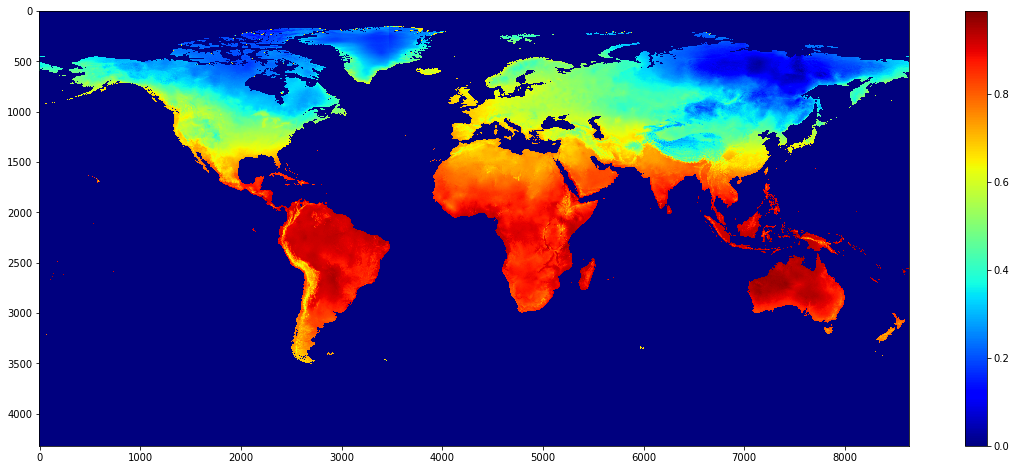

In [56]:
for var in variables:
    scaler = WorldClimScaler()

    for i in range(12):
        f_path = fpaths["tmin"]["2.5m"][i]
        arr = np.array(Image.open(f_path))
        scaled = scaler.fit_transform_single(arr)

        plot_clim_from_array(np.array(Image.fromarray(scaled)))
        patch_count = make_patches(scaled, i, output_dir, "train")
        break
    break

In [48]:
# np.expand_dims(np.random.rand(10,10), axis=2)
assert scaled.size == np.prod(scaled.shape)